In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter, FuncFormatter
import torch, pickle, numpy


# setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
nfft = 2**18
pi = 3.141592653589 
maxdist = 50
lightspeed = 299_792_458 
f_start, f_end = 76_010_000_056.0, 80_289_505_280.0
t_start, t_end =  2e-6, 66.1e-6
# ramp_slope = (f_start-f_end) / (t_start-t_end)
ramp_slope = 65_950.2e9
hertz_per_meter = ramp_slope / lightspeed
bins_per_meter = nfft / maxdist
fs = 22e6
Ts = 1/fs
beta = 2*pi*ramp_slope

folder = '/home/dgotzens/scripts/2.2_antenna-characteristics/measured/'
dists = [2.143, 8.099, 18.016, 32.284]

angles = [pickle.load(open(folder+f'a{int(dist):02d}_angle.pkl', 'rb')) for dist in dists]
degs = [list(map(lambda a : round(a*180/pi - 90), angle)) for angle in angles]
l_degs = [[deg.index(a) for a in sorted(set(deg)) if -60<a<60] for deg in degs]
l_sels = [[l for l,a in enumerate(angle) if -50<180/pi*a-90<50] for angle in angles]
angles_filtered = [[angle[l] for l in l_deg] for angle,l_deg in zip(angles,l_degs)]
#angles_filtered = [[angle[l] for l in l_sel] for angle,l_sel in zip(angles,l_sels)]
params = pickle.load(open(folder+'feparams.pkl', 'rb'))
tx,ty,rx,ry = params['txPosX'], params['txPosY'], params['rxPosX'], params['rxPosY']
vx, vy = params['vxPosX'], params['vxPosY']

ula = [[x if y==0 else -2000 for x,y in zip(vx,vy)].index(i) for i in range(max(vx)+1)]

folder = '/home/dgotzens/scripts/3.1_imaging/measured_gains/'
with open(folder+'gains.pkl', 'rb') as f:
    gains = pickle.load(f)
with open(folder+'taus.pkl', 'rb') as f:
    taus = pickle.load(f)

cpu


In [2]:
folder = '/home/dgotzens/recording/'
angle = pickle.load(open(folder + 'a02_angle.pkl', 'rb'))
l_deg = l_degs[0]
angle_deg = [180/pi*angle[l]-90 for l in l_deg]
gain = gains[0]
angle = torch.tensor(angle)[l_deg]
dBr = lambda x : 20*x.abs().log10() - 20*x.abs().log10().max()
data = torch.load(folder + 'a02_data.pt')[:,:,l_deg]
M,K,L = data.shape


### FFT

In [3]:
from torch.fft import fft, fftshift, ifftshift
N_range = 1024
range_fft = fft(torch.hann_window(M)[:,None,None]*data[:,ula,:], n=N_range, dim=0)
range_fft /= gain[ula,60,None]

N_azm = 120
azm_fft = fftshift(fft(torch.hann_window(len(ula))[:,None]*range_fft, n=N_azm, dim=1), dim=1)

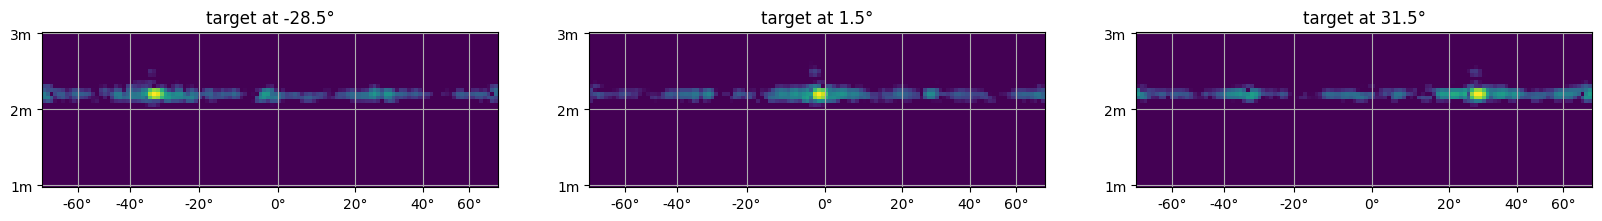

In [4]:
m_min = int(1 * N_range / maxdist)
m_max = int(3 * N_range / maxdist)
from math import sin
fig, axes = plt.subplots(1,3)
for l, ax in zip((30,60,90), axes):
    im=ax.imshow(dBr(azm_fft[m_min:m_max,:,l]), origin='lower', vmin=-40, vmax=0)
    ax.set_xticks([0.5*N_azm*(1+sin(angle[l]-pi/2)) for l in range(0, L, 20)] + [0.5*N_azm*(1+sin(pi/3))],\
                  [f'{round(angle_deg[l],-1):.0f}°' for l in range(0, L, 20)] + ['60°'])
    #ax.set_xticks([0.5*N_azm*(1+sin(angle[l]-pi/2)) for l in range(0, L, 3)], minor=True)
    ax.set_yticks(range(0,m_max-m_min, (m_max-m_min)//2),\
                  [f'{round(m/N_range*maxdist)}m' for m in range(m_min,m_max,(m_max-m_min)//2)])
    ax.grid()
    ax.set_title(f'target at {round(angle_deg[l],1)}°')
fig.set_figwidth(20)

### Backprojection

In [5]:
tau_meas = taus[0].unflatten(0,(K,L))
R = 80
sampledists = torch.linspace(1,3,R)
points = sampledists.unsqueeze(-1) * \
    torch.stack([\
        -torch.sin(angle-pi/2),\
        torch.zeros(L),\
        torch.cos(angle-pi/2)\
    ]).T.unsqueeze(1)
print(points.shape) # L,R,3

txpos = torch.tensor([tx,ty,[0]*len(tx)]).T.unsqueeze(1).unsqueeze(1)
rxpos = torch.tensor([rx,ry,[0]*len(rx)]).T.unsqueeze(1).unsqueeze(1)
tau = 1/lightspeed * ((txpos-points).square().sum(-1).sqrt() + (rxpos-points).square().sum(-1).sqrt())
print(tau.shape) # K,L,R
#gain_shifted = gain[:,:,None] * torch.exp(1j*2*pi*0 * (tau-tau_meas[:,:,None])) # K,L,R

# plt.imshow(tau[:,:,30])
# plt.colorbar()
# plt.show()
# plt.imshow(tau_meas[:,:]+0.1e-8, vmin=tau[:,:,30].min(), vmax=tau[:,:,30].max())
# plt.colorbar()
# plt.show()


torch.Size([119, 80, 3])
torch.Size([192, 119, 80])


In [6]:
weights=None
weights = gain[None,:,:,None]\
        * torch.exp(1j*beta*tau[None,:,:,:]\
        * torch.arange(M)[:,None,None,None] * Ts)\
        * torch.hann_window(M)[:,None,None,None] # M,K,L,R

P = 1000
T=L

In [8]:
fig = plt.figure()
ax = plt.axes()
im = ax.imshow(torch.zeros(R,L), origin='lower', vmin=-40, vmax=0)
ax.set_xticks(range(0, T, round(T/6)), [f'{round(angle_deg[l],-1)}°' for l in range(0,T,round(T/6))])
ax.set_yticks(range(0,R,R//2), [f'{round(sampledists.tolist()[r],1)}m' for r in range(0,R,R//2)])
ax.grid()
sample_abs = torch.zeros(P)
sample_idx = torch.zeros(P).long()

def init():
    im.set_data(torch.zeros(R,L))
    return im,

def update(t):
    global sample_abs, sample_idx
    img = torch.full((L*R,),1e-12)
    keep = sample_abs > sample_abs.max()/100
    print(f'{keep.sum()=}', end='\r')
    sample_idx = torch.where(keep, sample_idx, torch.randint(L*R, (P,)))
    sample_abs = (weights.flatten(2)[:,:,sample_idx].conj() * data[:,:,t,None]).sum((0,1)).abs()
    img[sample_idx] = sample_abs
    im.set_data(dBr(img).unflatten(0,(L,R)).T)
    return im,

from matplotlib.animation import FuncAnimation
anim = FuncAnimation(fig,update,init_func=init,interval=100,frames=T)
anim.save('/home/dgotzens/Schreibtisch/backproj_random_targets.mp4')
